In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline



import os, math
import joblib
from joblib import Parallel, delayed

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import cvxpy as cp
import torch, wandb


torch.manual_seed(0)

import pytorch_lightning as pl

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

rc('text', usetex=True)
rc('font', family='serif')

# OWN MODULES
from src.data.utils import get_data_tuples
from src.data.data_module import UNOSDataModule, UKRegDataModule, UNOS2UKRegDataModule
from src.models.organsync import OrganSync_Network

In [2]:
data = 'U2U'
batch_size = 256
synth=True

if data == 'UNOS':
    project = 'organsync-net'
    data_dir = '../data/processed'
    dm = UNOSDataModule(data_dir, batch_size=batch_size, is_synth=synth)
elif data == 'U2U':
    project = 'organsync-net-u2u'
    data_dir = '../data/processed_UNOS2UKReg_no_split'
    dm = UNOS2UKRegDataModule(data_dir, batch_size=batch_size, is_synth=synth, control=False)
    dm.prepare_data()
else:
    project = 'organsync-net-ukreg'
    data_dir = '../data/processed_UKReg/clinical_ukeld_2_ukeld'
    dm = UKRegDataModule(data_dir, batch_size=batch_size, is_synth=synth)
    dm.prepare_data()
    

In [3]:
dm.setup(stage='fit')
dm.setup(stage='test')


dm.train_dataloader().dataset.dataset.tensors[1].size(0) + dm.val_dataloader().dataset.dataset.tensors[1].size(0)+ dm.test_dataloader().dataset.tensors[1].size(0)

170726

In [4]:
dm._train_processed

,Unnamed: 0,RAGE,RCREAT,RINR,RSODIUM,RALBUMIN,SERUM_BILIRUBIN,INR,SERUM_CREATININE,SERUM_SODIUM,...,RAB_SURGERY_-1,RAB_SURGERY_0,RAB_SURGERY_1,RAB_SURGERY_2,DAGE,DBMI,RECEIVED_TX,DGRP_-1,DGRP_0,DGRP_1
51891,51891,0.117371,-0.514908,0.214023,-1.310648,-1.492767,0.011727,-0.155104,0.124080,0.981833,...,0,0,0,1,-0.034553,-0.788417,True,0,1,0
35730,35730,-0.242681,0.695749,0.413983,-0.593713,0.081497,0.661347,1.725926,1.491567,-0.797884,...,0,0,0,1,-1.261740,0.655829,True,0,1,0
27379,27379,0.057362,-0.436622,1.504246,-2.744518,-0.490963,1.115995,0.090247,-0.744712,-1.786615,...,0,1,0,0,-0.954943,0.226507,True,0,1,0
48430,48430,1.137519,1.683952,1.100616,0.123222,1.941991,1.815245,0.662735,0.966675,-0.797884,...,0,1,0,0,-1.077662,-0.334735,True,0,1,0
86586,86586,0.597440,-0.640422,-0.156809,0.840157,0.081497,-0.570642,-0.236888,-0.028810,1.575072,...,0,0,0,1,0.210884,-0.768253,True,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80834,80834,0.237388,-0.640422,-0.586639,-0.414479,-0.920308,-0.087232,-0.400456,-0.600963,-0.995630,...,0,1,0,0,-0.341350,0.055368,True,0,1,0
30550,30550,-0.242681,-0.344095,-0.716903,0.123222,0.081497,0.120996,-0.482240,-0.848241,-0.402391,...,0,0,0,1,-1.445818,-0.288473,True,0,1,0
91799,91799,0.717458,-1.094098,1.100616,-0.056012,-0.634078,-1.646859,-0.400456,-1.017252,-0.006898,...,0,0,0,1,0.947196,-0.084807,True,0,1,0
106607,106607,0.477423,1.391356,0.867365,-1.489882,1.083301,-0.364695,0.662735,1.611333,-2.182108,...,0,1,0,0,-0.586787,-0.112791,True,0,1,0


In [5]:
model_id = '30iz1r27'
params = wandb.restore(f'organsync_net.ckpt.ckpt', run_path=f'jeroenbe/{project}/{model_id}', replace=True)
model = OrganSync_Network.load_from_checkpoint(params.name).double()
trainer = pl.Trainer()
#trainer.test(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [6]:
dm.setup(stage='test')
dm.setup(stage='fit')

In [7]:
train_length = len(dm.train_dataloader().dataset.dataset)
X, O, Y, delt = dm.train_dataloader().dataset.dataset[torch.randint(0, train_length,  (500,))]#

catted = torch.cat((X, O), dim=1).double()


with torch.no_grad():
    U = model.representation(catted)

In [8]:
n = 50
test_length = len(dm.test_dataloader().dataset)

with torch.no_grad():
    X_new, O_new, Y_, delt_= dm.test_dataloader().dataset[torch.randint(0, test_length,  (n,))]
    new_pair = torch.cat((X_new, O_new), dim=1).double() 
    u = model.representation(new_pair) # synth_u
    

In [9]:
lambd=np.linspace(0, .2, 11)
result=dict()


def convex_opt(u, lambd):
    a = cp.Variable(U.shape[0])

    objective = cp.Minimize(cp.norm2(a@U - u)**2 + lambd * cp.norm1(a))
    constraints = [0 <= a, a <= 1, cp.sum(a) == 1]
    prob = cp.Problem(objective, constraints)

    _ = prob.solve(warm_start=True, solver=cp.SCS)

    return a.value, (a.value @ Y.numpy()).item()

for l in lambd:
    res = Parallel(n_jobs=joblib.cpu_count())(delayed(convex_opt)(u_, l) for u_ in u)
    result[f'lambda: {l}'] = res

In [10]:
RES = result#.shape# = np.array(result, dtype=object)

In [11]:
synth_rmse = np.array([])
synth_diff = np.array([])
synth_diff_std = np.array([])
synth_std = np.array([])
avg_a = np.array([])
std_a = np.array([])

avg_top_a = np.array([])
std_top_a = np.array([])

for k in RES.keys():
    y_ = np.array(RES[k], dtype=object)[:,1].astype(float)
    y_diff = y_ * dm.std + dm.mean
    
    rmse = np.sqrt((y_ - Y_.numpy())**2)
    rmse_diff = np.abs(y_diff - (Y_.numpy() * dm.std + dm.mean))
    
    synth_rmse = np.append(synth_rmse, rmse.mean())
    synth_std = np.append(synth_std, rmse.std())
    
    synth_diff = np.append(synth_diff, rmse_diff.mean())
    synth_diff_std = np.append(synth_diff_std, synth_diff.std())
    
    
    a_s = np.array([*np.array(RES[k], dtype=object)[:,0]])
    as_3 = np.where(a_s > 1e-5, a_s, np.zeros(a_s.shape))

    as_3_nz = np.count_nonzero(as_3, axis=1)
    
    avg_a = np.append(avg_a, as_3_nz.mean())
    std_a = np.append(std_a, as_3_nz.std())
    
    k=50
    top_k = np.partition(a_s,-k, axis=1)[:,-k:]
    avg_top_a = np.append(avg_top_a, top_k.mean())
    std_top_a = np.append(std_top_a, top_k.std())
    
    

In [12]:
print(synth_rmse)
print(synth_std / np.sqrt(n))
print('---')

print(avg_a)
print(std_a / np.sqrt(n))

[5.83460341e-05 9.30166091e-05 5.08316131e-05 4.15242535e-05
 4.55378037e-05 3.85498121e-05 3.38342208e-05 2.27696217e-05
 2.82847982e-05 2.53063970e-05 2.67371250e-05]
[8.65096945e-06 1.30528874e-05 8.55419340e-06 6.57043090e-06
 8.76559799e-06 5.65865992e-06 4.97454630e-06 3.73293025e-06
 4.54661171e-06 3.57951747e-06 3.97931520e-06]
---
[371.24 328.68 304.06 298.2  302.04 297.12 295.44 292.18 277.64 293.
 291.94]
[20.18832455 22.45021942 24.31658545 23.84927672 22.86606149 23.00567999
 22.92529014 22.44642849 21.70346995 21.71907917 21.78212864]


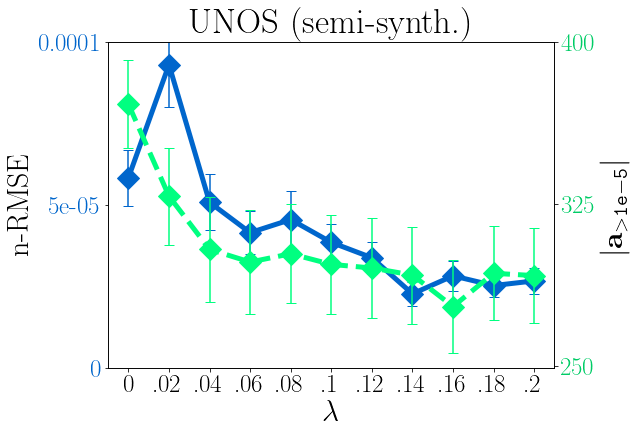

In [13]:
def my_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str

major_formatter = FuncFormatter(my_formatter)


# FIGURE
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

ax2 = ax1.twinx()

line_kwargs = {
    'capsize': 5, 'linewidth': 5, 'marker':'D', 'elinewidth': 1.5, 'markersize':15
}

blue='#0066CC'
green='#00FF80'


ax1.errorbar(lambd, synth_rmse, synth_std/np.sqrt(n), color=blue, **line_kwargs)
ax2.errorbar(lambd, avg_a, std_a/np.sqrt(n), color=green, linestyle='--', **line_kwargs)


ax1.set_ylim([0, 1e-04])
ax1.set_yticks([0, 5e-5, 1e-4])
ax1.set_yticklabels([0,  5e-5, 1e-4], fontsize=25, color=blue)
ax1.set_ylabel('n-RMSE', fontsize=30)
ax1.set_xlabel(r'$\lambda$', fontsize=30)
ax1.set_xticks(lambd)
ax1.set_xticklabels(lambd, fontsize=25)
ax1.xaxis.set_major_formatter(major_formatter)
ax1.set_title(f'UNOS (semi-synth.)', fontsize=35)


ax2.set_ylabel(r'$|\mathbf{a}_\mathtt{>1e-5}|$', fontsize=30)
ax2.set_yticks(np.linspace(250, 400, 3))
ax2.set_yticklabels(np.linspace(250, 400, 3).astype(int), fontsize=25, color='#00CC66')

fig.savefig(f'{data}_synth_a.pdf', bbox_inches = "tight")